In [13]:
import pandas as pd
import requests
import json
from urllib.request import urlopen
from IPython.display import JSON
from pandas.io.json import json_normalize

from datetime import datetime
from datetime import timedelta

import time

# Config & functions

In [128]:
df_name = load_account()

## Function Save to excel with multiple sheet
def DF_TO_EXCEL_MUL(dfs, filename):
    writer = pd.ExcelWriter(filename, engine='xlsxwriter')
    for sheetname, df in dfs.items():  # loop through `dict` of dataframes
        df.to_excel(writer, sheet_name=sheetname)  # send df to writer
        worksheet = writer.sheets[sheetname]  # pull worksheet object
        for idx, col in enumerate(df):  # loop through all columns
            series = df[col]
            max_len = max((
                series.astype(str).map(len).max(),  # len of largest item
                len(str(series.name))  # len of column name/header
                )) + 1  # adding a little extra space
            worksheet.set_column(idx, idx, max_len)  # set column width
    writer.save()

## Load Account Name
def load_account():
    df_name = pd.read_excel('data/List of well-known Names used to identify accounts.xlsx')
    df_name.fillna('', inplace=True)
    df_name = df_name.sort_values(by='XRP', ascending=False)
    return df_name

## Find Account Description
def find_desc(account):
    if not dir().count('df_name'):
        df_name = load_account()
        
    try:
        _df = df_name.loc[df_name.account == account, ['name','desc']].astype(str)
        return '{}{}'.format(_df.name.values[0], '({})'.format(_df.desc.values[0]) if len(_df.desc.values[0]) > 0 else '')
    except:
        return 'Unknow'

## Load transactions
def load_transactions(ACCOUNT_ADDRESS):
    start = datetime.now() - timedelta(days=90)
    date_start = start.strftime("%Y-%m-%dT%H:%M:%SZ")

    end = datetime.now()
    date_end = end.strftime("%Y-%m-%dT%H:%M:%SZ")

    url = 'https://data.ripple.com/v2/accounts/{ACCOUNT_ADDRESS}/transactions?start={date_start}&end={date_end}&type=Payment&result=tesSUCCESS&limit=1000&descending=True'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS, date_start=date_start, date_end=date_end)

    header = {
      "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
      "X-Requested-With": "XMLHttpRequest"
    }

    r = requests.get(url, headers=header)
    data = json.loads(r.text)

    return data

## Convert JSON to DataFrame
def convert_to_dataframe(account, data):
    if data['result'] == "error":
        print(data['message'])
        return
    
    trans_list=[]
    for d in data['transactions']:
        account_desc = ''
        d_date = d['date']
        d_hash = d['hash']
        d_tx_from = d['tx']['Account']
        d_tx_from_desc = ''
        d_tx_type = d['tx']['TransactionType']
        d_tx_flow = ''
        d_tx_to = d['tx']['Destination']
        d_tx_to_desc = ''
        d_tx_dt = d['tx']['DestinationTag'] if d['tx'].__contains__('DestinationTag') else ''
        
        d_tx_amount = 0
        d_tx_currency = ''
        d_tx_issuer = ''
        if str(type(d['tx']['Amount'])) != "<class 'dict'>":
            d_tx_amount = float(d['tx']['Amount'])  / 1000000
        else:
            d_tx_amount = float(d['tx']['Amount']['value']) / 1000000
            d_tx_currency = d['tx']['Amount']['currency'][0:8]
            d_tx_issuer = d['tx']['Amount']['issuer']
        
        d_meta_delivered_amount = 0
        if str(type(d['meta']['delivered_amount'])) != "<class 'dict'>":
            d_meta_delivered_amount =  float(d['meta']['delivered_amount'])  / 1000000
        else:
            d_meta_delivered_amount =  float(d['meta']['delivered_amount']['value'])  / 1000000
            
        d_tx_fee = float(d['tx']['Fee']) / 1000000
        d_meta_result = d['meta']['TransactionResult']

        trans_list.append([account, account_desc, d_date, d_hash, d_tx_from, d_tx_from_desc, d_tx_type, d_tx_flow, d_tx_to, d_tx_to_desc, d_tx_dt, d_tx_amount, d_tx_currency, d_tx_issuer, d_meta_delivered_amount, d_tx_fee, d_meta_result])

    df_trans = pd.DataFrame(trans_list, columns=['account','Account Desc', 'Date','Tx hash','From','From Desc','Type','Flow','To','To Desc','DT','Amount', 'Currency', 'Issuer', 'Delivered Amount', 'Fee', 'Result'])
    
    df_trans['Account Desc'] = df_trans['account'].apply(lambda x: find_desc(x))
    df_trans['From Desc'] = df_trans['From'].apply(lambda x: find_desc(x))
    df_trans['To Desc'] = df_trans['To'].apply(lambda x: find_desc(x))
    df_trans['Flow'] = df_trans[['account', 'To']].apply(lambda x: 'IN' if x['account'] == x['To'] else 'OUT', axis=1)
    
    return df_trans

def account_info(ACCOUNT_ADDRESS):
    url = 'https://api.xrpscan.com/api/v1/account//{ACCOUNT_ADDRESS}'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS)

    header = {
      "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
      "X-Requested-With": "XMLHttpRequest"
    }

    r = requests.get(url, headers=header)
    data = json.loads(r.text)

    acc_list = {'account': [data['account']], 'accountName':[find_desc(data['account'])], 'parent': [data['parent']], 'parentName':[ data['parentName']['name'] if data['parentName'] != None else ''] , 'inception':[data['inception']] , 'initial_balance':[ data['initial_balance'] ], 'xrpBalance':[float(data['xrpBalance'])]}
    df_account = pd.DataFrame(acc_list, columns=['account','accountName','parent','parentName','inception','initial_balance','xrpBalance'])
    
    return df_account

# Get account infomation

In [120]:
import requests

ACCOUNT_ADDRESS = 'rHUAEDchvGi6FcckvjvnQdKX7tC2Jiwb3f'
url = 'https://api.xrpscan.com/api/v1/account//{ACCOUNT_ADDRESS}'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS)

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)
data = json.loads(r.text)
JSON(data, expanded=True)


<IPython.core.display.JSON object>

In [127]:
data['parentName']['name'] if data['parentName'] != None else ''

''

In [41]:
def account_info(ACCOUNT_ADDRESS):
    url = 'https://api.xrpscan.com/api/v1/account//{ACCOUNT_ADDRESS}'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS)

    header = {
      "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
      "X-Requested-With": "XMLHttpRequest"
    }

    r = requests.get(url, headers=header)
    data = json.loads(r.text)

    acc_list = {'account': [data['account']], 'parent': [data['parent']], 'parentName':[ data['parentName']['name']] , 'inception':[data['inception']] , 'initial_balance':[ data['initial_balance'] ], 'xrpBalance':[data['xrpBalance']]}
    df_account = pd.DataFrame(acc_list, columns=['account','parent','parentName','inception','initial_balance','xrpBalance'])
    
    return df_account

In [ ]:
from IPython.display import JSON
JSON(r.text, expanded=True)

# Get Payment flows

In [ ]:
ACCOUNT_ADDRESS = 'rEb8TK3gBgk5auZkwc6sHnwrGVJH8DuaLh'
url = 'https://api.xrpscan.com/api/v1/account/{ACCOUNT_ADDRESS}/payment_flows'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS)

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)
JSON(r.text, expanded=True)

# Get well-known account

In [ ]:
url = 'https://api.xrpscan.com/api/v1/names/well-known'

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)
JSON(r.text, expanded=True)

In [ ]:
import requests
import json
from pandas.io.json import json_normalize

url = 'https://api.xrpscan.com/api/v1/names/well-known'

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)

data = json.loads(r.text)
df = json_normalize(data)
df.fillna('', inplace=True)
df.loc[df.name.str.contains('Binance')]

In [ ]:
df.to_excel('data/List of well-known Names used to identify accounts.xlsx')

# Get Account Balances

In [56]:
import pandas as pd
import requests
import json
from urllib.request import urlopen
from IPython.display import JSON
from pandas.io.json import json_normalize

from datetime import datetime
from datetime import timedelta

now = datetime.now() - timedelta(days=1)
date_time = now.strftime("%Y-%m-%d")

ACCOUNT_ADDRESS = 'rEahGW5VLYQH2vGBfFmbv9BBpWSTDoukGR'
url = 'https://data.ripple.com/v2/accounts/{ACCOUNT_ADDRESS}/balances?currency=XRP&date={date_time}T00:00:00Z&limit=3'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS, date_time=date_time)

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)

data = json.loads(r.text)
JSON(data, expanded=True)

<IPython.core.display.JSON object>

# Get daily reports

In [55]:
import pandas as pd
import requests
import json
from urllib.request import urlopen
from IPython.display import JSON
from pandas.io.json import json_normalize

from datetime import datetime
from datetime import timedelta

now = datetime.now() - timedelta(days=1)
date_time = now.strftime("%Y-%m-%d")

url = 'https://data.ripple.com/v2/reports/{date_time}T00:00:00Z?accounts=true&payments=true'.format(date_time=date_time)

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)

data = json.loads(r.text)
JSON(data, expanded=True)

<IPython.core.display.JSON object>

# Get Account balances

## Today Balance

In [ ]:
import pandas as pd
import requests
import json
from urllib.request import urlopen
from IPython.display import JSON
from pandas.io.json import json_normalize

from datetime import datetime
from datetime import timedelta
import time

df_name = pd.read_excel('data/List of Monitor Accounts.xlsx')
df_name.fillna('', inplace=True)

now = datetime.now()
date_time = now.strftime("%Y-%m-%d")

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

df_xrp = df_name.copy(deep=True)

print('Begin')

df_name = df_name.sort_values(by='XRP', ascending=False)
df_name = df_name[:100] # get top 30 balance

for _, row in df_name.iterrows():
    print('{}-{}-{}'.format(row['account'], row['name'], row['desc']))

    ACCOUNT_ADDRESS = row['account']
    
    url = 'https://data.ripple.com/v2/accounts/{ACCOUNT_ADDRESS}/balances?currency=XRP&date={date_time}T00:00:00Z&limit=3'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS, date_time=date_time)

    r = requests.get(url, headers=header)

    data = json.loads(r.text)
    if data['result'] != 'error':
        df_xrp.loc[df_xrp['account'] == ACCOUNT_ADDRESS, date_time] = float(data['balances'][0]['value'])
        
    #print('-----------------------')
    time.sleep(0.001)   # Delays for 1 seconds. You can also use a float value.

df_xrp['verified'] = df_xrp['verified'].astype(bool)

df_xrp.to_excel('data/{}-List of Monitor Accounts.xlsx'.format(date_time), index=False)

print('Done.')

## Get Account Balances History

In [ ]:
import pandas as pd
import requests
import json
from urllib.request import urlopen
from IPython.display import JSON
from pandas.io.json import json_normalize

from datetime import datetime
from datetime import timedelta
import time

df_name = pd.read_excel('data/List of Monitor Accounts.xlsx')
df_name.fillna('', inplace=True)

now = datetime.now()  - timedelta(days=30)
date_time = now.strftime("%Y-%m-%d")

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

df_xrp = df_name.copy(deep=True)

print('Begin')

df_name = df_name.sort_values(by='XRP BALANCES', ascending=False)
df_name = df_name[:100] # get top 30 balance

for _, row in df_name.iterrows():
    print('{}-{}-{}'.format(row['account'], row['name'], row['desc']))

    ACCOUNT_ADDRESS = row['account']
    
    url = 'https://data.ripple.com/v2/accounts/{ACCOUNT_ADDRESS}/balances?currency=XRP&date={date_time}T00:00:00Z&limit=3'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS, date_time=date_time)

    r = requests.get(url, headers=header)

    data = json.loads(r.text)
    if data['result'] != 'error':
        df_xrp.loc[df_xrp['account'] == ACCOUNT_ADDRESS, date_time] = float(data['balances'][0]['value'])
        
    #print('-----------------------')
    time.sleep(0.001)   # Delays for 1 seconds. You can also use a float value.

df_xrp['verified'] = df_xrp['verified'].astype(bool)

df_xrp.to_excel('data/{}-List of Monitor Accounts.xlsx'.format(date_time), index=False)

print('Done.')

## Get last 90 days balances

In [88]:
name_desc = 'Unknow'
ACCOUNT_ADDRESS = 'rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c'

now = datetime.now()  - timedelta(days=90)
date_time = now.strftime("%Y-%m-%d")
trans_list = []
for i in range(1, 91):
    
    date_time = now.strftime("%Y-%m-%d")
    
    url = 'https://data.ripple.com/v2/accounts/{ACCOUNT_ADDRESS}/balances?currency=XRP&date={date_time}T00:00:00Z&limit=3'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS, date_time=date_time)

    r = requests.get(url, headers=header)

    data = json.loads(r.text)
    if data['result'] != 'error':
        value = float(data['balances'][0]['value'])
        trans_list.append([i, ACCOUNT_ADDRESS, date_time, value])
        
    
    #print('-----------------------')
    time.sleep(0.001)   # Delays for 1 seconds. You can also use a float value.
    now = now  + timedelta(days=1)
    #print(date_time)

df_balance = pd.DataFrame(trans_list, columns=['ID', 'Account', 'Date', 'Balance'])
df_balance.set_index('Date', inplace=True)
df_balance

,ID,Account,Balance
Date,,,
2020-02-15,1,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,2.481310e+02
2020-02-16,2,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,2.481310e+02
2020-02-17,3,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,2.481310e+02
2020-02-18,4,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,3.862481e+05
2020-02-19,5,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,4.321130e+05
...,...,...,...
2020-05-10,86,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,2.828093e+06
2020-05-11,87,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,2.828093e+06
2020-05-12,88,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,1.246965e+02


In [89]:
df_balance.to_excel('data/Account_balance-{}-{}.xlsx'.format(name_desc, ACCOUNT_ADDRESS))

## Display in Graph

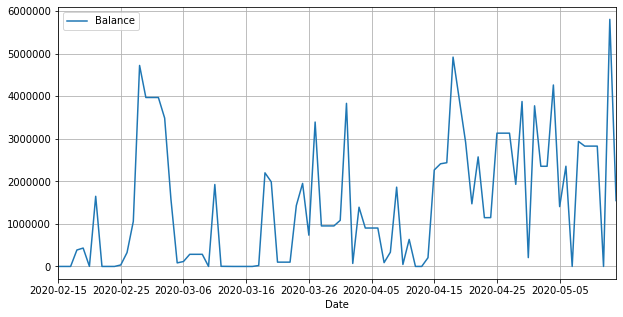

In [90]:
import matplotlib.pyplot as plt

df_balance[['Balance']].plot(grid=True, figsize=(10, 5))
plt.show()

## Find Transactions

In [91]:
df_name = load_account()
# ACCOUNT_ADDRESS = 'rBszWJzYpNoqoY4xKuGUpN23b6EBT41ocF'
print(ACCOUNT_ADDRESS)
data = load_transactions(ACCOUNT_ADDRESS)
df_trans = convert_to_dataframe(ACCOUNT_ADDRESS, data)
#JSON(data, expanded=True)
df_trans

rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c


,account,Account Desc,Date,Tx hash,From,From Desc,Type,Flow,To,To Desc,DT,Amount,Currency,Issuer,Delivered Amount,Fee,Result
0,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,Unknow,2020-05-15T06:23:10+00:00,9A535814FA68FE2D3E9A7D1D320C7C560D7E2CF17EC71E...,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,Unknow,Payment,OUT,rUW9toSjQkLY6EspdnBJP2paG4hWKmNbMh,KuCoin(1),1864254189,3.490198e+05,,,3.490198e+05,0.000045,tesSUCCESS
1,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,Unknow,2020-05-14T21:17:40+00:00,E2A4719B6F30D48A7F540302BA818043D23B2710ADB558...,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,Unknow,Payment,OUT,rEb8TK3gBgk5auZkwc6sHnwrGVJH8DuaLh,Binance(1),109694778,4.013753e+03,,,4.013753e+03,0.000045,tesSUCCESS
2,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,Unknow,2020-05-14T15:18:21+00:00,441A297E54F8B3CF5EF80909BB127F8596ED603E42018B...,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,Unknow,Payment,OUT,rnVGK7Yuiff2H7jhUwm8MpkQyHBHG9KWd4,Unknow,2,2.000000e+04,,,2.000000e+04,0.000045,tesSUCCESS
3,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,Unknow,2020-05-14T08:50:01+00:00,9CDC826BCDB389276AD17E50BD85CA0AEA5BA6316760F7...,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,Unknow,Payment,OUT,rUW9toSjQkLY6EspdnBJP2paG4hWKmNbMh,KuCoin(1),1864254189,1.182955e+05,,,1.182955e+05,0.000045,tesSUCCESS
4,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,Unknow,2020-05-14T00:09:00+00:00,D8215791DF9FCE94D93CD09FFEA12BDB7B459935EC28FC...,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,Unknow,Payment,OUT,rsFd54Hpp5msvbo2NJwW4f1dKFFHQwdbcN,Unknow,,5.436969e+04,,,5.436969e+04,0.000045,tesSUCCESS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,Unknow,2020-02-18T19:48:41+00:00,C1D6C338CE62E20379A8FC5B75DC66C2F2C0520244415D...,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,Unknow,Payment,OUT,rnVGK7Yuiff2H7jhUwm8MpkQyHBHG9KWd4,Unknow,2,3.640000e+05,,,3.640000e+05,0.000045,tesSUCCESS
538,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,Unknow,2020-02-18T04:48:40+00:00,3A76230BE3A00985DFDC027E106D0A035E8298BE501F07...,rhKrvXY8zRvVyDLT4nfXB86HyhqQyvcr4c,KuCoin(3),Payment,IN,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,Unknow,2743,4.182731e+05,,,4.182731e+05,0.000012,tesSUCCESS
539,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,Unknow,2020-02-17T13:02:22+00:00,580BA8EC5914EAFFB88D71781882E184587AC23FE874D6...,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,Unknow,Payment,OUT,rEb8TK3gBgk5auZkwc6sHnwrGVJH8DuaLh,Binance(1),102399177,5.000000e+05,,,5.000000e+05,0.000045,tesSUCCESS
540,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,Unknow,2020-02-17T06:13:22+00:00,9133DD588FB0DFF58B8E867C0D47675555ABF241C2CF42...,rMjjMBDVwWdRsbC4QaU98MXQgSGFVv2G1c,Unknow,Payment,OUT,rwyfuY3BRujqfryfu5RocRYLYXTyXf7638,Unknow,28,1.114000e+06,,,1.114000e+06,0.000045,tesSUCCESS


## Group by for monitor flow IN/OUT

In [92]:
df_flow_in = df_trans.loc[df_trans.Flow == 'IN'].groupby(['From', 'From Desc']).agg({"Amount": "sum"})
df_flow_in

,,Amount
From,From Desc,
r369aVmXp8nWrkDEBVHX5fiy1jPeb77LRh,Unknow,1.300000e+06
r4sRyacXpbh4HbagmgfoQq8Q3j8ZJzbZ1J,Coinbase(6),6.239694e+05
r9dJLh33Gb28ikkED5sCfafUZ43uzH5E2T,Unknow,4.503300e+03
rBTkSC7aJGVenCWeJWhwKNqa8hK2Fzsm6i,PDAX(3),5.042738e+04
rBx8MSdavnHCnbPb39yrZweCSamjP9vLkE,Huobi Global(6),9.000000e+06
rDV48VasQrLaAMSFKHtU2fDM3PSa7rsrkw,Unknow,3.303802e+07
rDsbeomae4FXwgQTJp9Rs64Qg9vDiTCdBv,Bitstamp(1),1.930000e+05
rG5TdVxaMgdV9nrxJMQTiJVQ8HWBqAfRd3,Unknow,1.200000e+07
rGm7zR92C6xosV5txQb8z5R4eCzADdfLoZ,Unknow,1.694991e+07


In [93]:
df_flow_out = df_trans.loc[df_trans.Flow == 'OUT'].groupby(['To', 'To Desc']).agg({"Amount": "sum"})
df_flow_out

,,Amount
To,To Desc,
r33hypJXDs47LVpmvta7hMW9pR8DYeBtkW,Independent Reserve,8.907559e+06
r9dJLh33Gb28ikkED5sCfafUZ43uzH5E2T,Unknow,2.751120e+04
rDV48VasQrLaAMSFKHtU2fDM3PSa7rsrkw,Unknow,3.028316e+07
rDsbeomae4FXwgQTJp9Rs64Qg9vDiTCdBv,Bitstamp(1),5.750000e+06
rEahGW5VLYQH2vGBfFmbv9BBpWSTDoukGR,Unknow,1.499950e+05
rEb8TK3gBgk5auZkwc6sHnwrGVJH8DuaLh,Binance(1),7.709456e+07
rEbcQtDSfCJNFoQGMtwae2NkDBA6Po6Crk,Unknow,1.376571e+06
rGm7zR92C6xosV5txQb8z5R4eCzADdfLoZ,Unknow,1.000000e+05
rKSQu6VFnfmaL84HxoZWKQrMa6iRz9pmFo,Unknow,4.446628e+04


## Get Account info

In [133]:
ACCOUNT_ADDRESS='rfjW34DYFGF6nZHj8zJJK3dnD7nZoeoAAU'
df_account_info = account_info(ACCOUNT_ADDRESS)
ac_list = []
for c in list(df_account_info):
    ac_list.append([c, df_account_info[c].values[0]])
    
cols = ['desc','info']
df_account_info_x = pd.DataFrame(ac_list, columns=cols)
df_account_info_x.set_index('desc', inplace=True)

print(df_account_info_x.to_csv(sep='\t'))

desc	info
account	rfjW34DYFGF6nZHj8zJJK3dnD7nZoeoAAU
accountName	Unknow
parent	rJYQKfsTi8XCLZ1vGSf9CxiL4prz5bvbtz
parentName	UPbit
inception	2019-08-16T05:52:00.000Z
initial_balance	20
xrpBalance	886706.821337



## Export data to Excel

In [95]:
dfs = {'account_info': df_account_info_x, 'balance': df_balance, 'transactions': df_trans, 'flow_in': df_flow_in, 'flow_out': df_flow_out}
filename = 'data/{}-TAG_FLOW-{}-{}.xlsx'.format(date_time, name_desc, ACCOUNT_ADDRESS)
DF_TO_EXCEL_MUL(dfs, filename)
print('Done!')

Done!


# Get Transactions

## Main function

In [ ]:
frames = []
df_name.fillna('', inplace=True)
for _, row in df_name.iterrows():
    print('{}-{}-{}'.format(row['account'], row['name'], row['desc']))
    ACCOUNT_ADDRESS = row['account']
    data = load_transactions(ACCOUNT_ADDRESS)
    
    if data.__contains__('result'):
        if data['result'] == 'success' and data['count'] > 0:
            df_tran = convert_to_dataframe(ACCOUNT_ADDRESS, data)
            frames.append(df_tran)

df_trans = pd.concat(frames)
df_trans.tail()

## Load Account Name

In [10]:
## Load Account Name
def load_account():
    df_name = pd.read_excel('data/List of well-known Names used to identify accounts.xlsx')
    df_name.fillna('', inplace=True)
    df_name = df_name.sort_values(by='XRP', ascending=False)
    return df_name

## Load transactions

In [7]:
## Load transactions
def load_transactions(ACCOUNT_ADDRESS):
    start = datetime.now() - timedelta(days=90)
    date_start = start.strftime("%Y-%m-%dT%H:%M:%SZ")

    end = datetime.now()
    date_end = end.strftime("%Y-%m-%dT%H:%M:%SZ")

    url = 'https://data.ripple.com/v2/accounts/{ACCOUNT_ADDRESS}/transactions?start={date_start}&end={date_end}&type=Payment&result=tesSUCCESS&limit=1000&descending=True'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS, date_start=date_start, date_end=date_end)

    header = {
      "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
      "X-Requested-With": "XMLHttpRequest"
    }

    r = requests.get(url, headers=header)
    data = json.loads(r.text)

    return data

## Convert JSON to DataFrame

In [26]:
## Convert JSON to DataFrame
def convert_to_dataframe(account, data):
    if data['result'] == "error":
        print(data['message'])
        return
    
    trans_list=[]
    for d in data['transactions']:
        account_desc = ''
        d_date = d['date']
        d_hash = d['hash']
        d_tx_from = d['tx']['Account']
        d_tx_from_desc = ''
        d_tx_type = d['tx']['TransactionType']
        d_tx_flow = ''
        d_tx_to = d['tx']['Destination']
        d_tx_to_desc = ''
        d_tx_dt = d['tx']['DestinationTag'] if d['tx'].__contains__('DestinationTag') else ''
        
        d_tx_amount = 0
        d_tx_currency = ''
        d_tx_issuer = ''
        if str(type(d['tx']['Amount'])) != "<class 'dict'>":
            d_tx_amount = float(d['tx']['Amount'])  / 1000000
        else:
            d_tx_amount = float(d['tx']['Amount']['value']) / 1000000
            d_tx_currency = d['tx']['Amount']['currency'][0:8]
            d_tx_issuer = d['tx']['Amount']['issuer']
        
        d_meta_delivered_amount = 0
        if str(type(d['meta']['delivered_amount'])) != "<class 'dict'>":
            d_meta_delivered_amount =  float(d['meta']['delivered_amount'])  / 1000000
        else:
            d_meta_delivered_amount =  float(d['meta']['delivered_amount']['value'])  / 1000000
            
        d_tx_fee = float(d['tx']['Fee']) / 1000000
        d_meta_result = d['meta']['TransactionResult']

        trans_list.append([account, account_desc, d_date, d_hash, d_tx_from, d_tx_from_desc, d_tx_type, d_tx_flow, d_tx_to, d_tx_to_desc, d_tx_dt, d_tx_amount, d_tx_currency, d_tx_issuer, d_meta_delivered_amount, d_tx_fee, d_meta_result])

    df_trans = pd.DataFrame(trans_list, columns=['account','Account Desc', 'Date','Tx hash','From','From Desc','Type','Flow','To','To Desc','DT','Amount', 'Currency', 'Issuer', 'Delivered Amount', 'Fee', 'Result'])
    
    df_trans['Account Desc'] = df_trans['account'].apply(lambda x: find_desc(x))
    df_trans['From Desc'] = df_trans['From'].apply(lambda x: find_desc(x))
    df_trans['To Desc'] = df_trans['To'].apply(lambda x: find_desc(x))
    df_trans['Flow'] = df_trans[['account', 'To']].apply(lambda x: 'IN' if x['account'] == x['To'] else 'OUT', axis=1)
    
    return df_trans


## Find Account Description

In [9]:
def find_desc(account):
    try:
        _df = df_name.loc[df_name.account == account, ['name','desc']].astype(str)
        return '{}{}'.format(_df.name.values[0], '({})'.format(_df.desc.values[0]) if len(_df.desc.values[0]) > 0 else '')
    except:
        return 'Unknow'
    